In [1]:
import numpy as np
import cv2 as cv
import tensorflow as tf
import os
import matplotlib.pyplot as plt

# New data: VCR, GCE, PIE

Loading the new data.


In [2]:
#load images

XDIM = 2048
YDIM = 11*XDIM//8 # tried to get an arbitrary approximation that's also highly divisible by 2

#might want to do 1024 x 1024 instead, idk.

def load_marsh_images(folder):
    images = []
    
    for i in range(1,12):
        img = cv.imread(os.path.join(folder,"Band%d.jpg" % i))
        #print("Band%d.jpg" % i)
        if img is not None:
            #convert to black and white
            img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            img = cv.resize(img,(YDIM, XDIM))
            #warp so the mask is square
            #img = cv.warpPerspective(img,Mpad,(SIZE+2*PAD,SIZE+2*PAD))
            images.append(img)
    return images


In [3]:
gce_imgs = load_marsh_images("train_jpg/GCE")
pie_imgs = load_marsh_images("train_jpg/PIE")
vcr_imgs = load_marsh_images("train_jpg/VCR")
images = np.array([gce_imgs,pie_imgs,vcr_imgs])

In [4]:
#images = np.array([gce_imgs,pie_imgs,vcr_imgs])
images.shape

(3, 11, 2048, 2816)

In [4]:
#load masks
gce_mask = cv.imread("new-masks/updated_GCE_mask.jpg")
pie_mask = cv.imread("new-masks/updated_PIE_mask.jpg")
vcr_mask = cv.imread("new-masks/updated_VCR_map.jpg")

new_masks = [cv.cvtColor(gce_mask, cv.COLOR_BGR2GRAY), 
         cv.cvtColor(pie_mask, cv.COLOR_BGR2GRAY), 
         cv.cvtColor(vcr_mask, cv.COLOR_BGR2GRAY)]
masks = []
for m in new_masks:
    m = cv.resize(m,(YDIM,XDIM))
    masks.append(m)
new_masks = masks



In [164]:
#change the values in the mask to integers from 1 to 5 instead of the weird 0-255 values currently in there

#THRESH = [90,120,140,180]
#merge tidal flats
THRESH = [120,140,180]


masks = []
weights = []
for mask in new_masks:
    int_mask = np.zeros_like(mask,dtype=int)
    for t in THRESH:
        is_bigger = mask >= t
        is_bigger = is_bigger.astype(int)
        int_mask = int_mask + is_bigger
        
    #the final one is the unlabeled stuff; so we get that and convert it to 0 on unlabeled and 1 on labeled
    #is_bigger = is_bigger.astype(bool)
    is_bigger = np.logical_not(is_bigger)
    is_bigger = is_bigger.astype(int)
    is_bigger = np.reshape(is_bigger, (1,XDIM,YDIM))
    
    int_mask = np.reshape(int_mask, (1,XDIM,YDIM))
    masks.append(int_mask)
    weights.append(is_bigger)
        
masks = np.array(masks)
weights = np.array(weights)



[0 1 2 3] [ 2701692  1173709   720434 12705669]


In [180]:
nums,counts=np.unique(masks,return_counts=True)
print(nums,counts)

#inverted frequencies for weights
inv_freq = np.array(counts,dtype=float)**(-1)
inv_freq = inv_freq/np.sum(inv_freq)
inv_freq[-1]=0
inv_freq= list(inv_freq)
inv_freq


[0 1 2 3] [ 2701692  1173709   720434 12705669]


[0.1376544403077543, 0.31685869337624345, 0.516216475268987, 0.0]

## Exploring new data

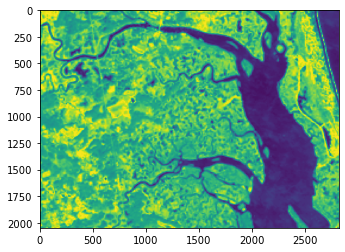

In [7]:
ax = plt.axes()

ax.imshow(pie_imgs[6])

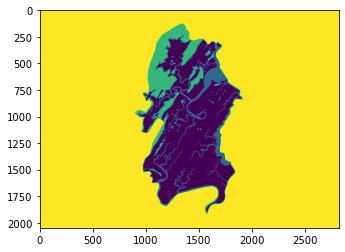

In [170]:
#look at new data
#plt.imshow(gce_mask)
#plt.imshow(pie_mask)
ax = plt.axes()


plt.imshow(masks[2,0,:,:],vmin=0,vmax=3)
#plt.imshow(grey_vcr_mask)
#it shows in the notebook!




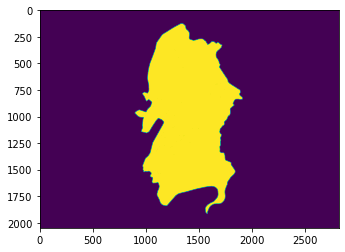

In [9]:
plt.imshow(weights[2][0])


## Test and train splits

I'm going to try a naive thing where I just convert the upper half of the mask to the unknown class.



In [196]:
te_masks = []
tr_masks = []
not_care = len(THRESH)


for m in masks:
    x = np.zeros_like(m)
    y = np.zeros_like(m)
    x.fill(not_care)
    y.fill(not_care)
    #x = x + m
    #y = y + m
    x[0,:XDIM//2,:]=m[0,:XDIM//2,:]
    #y[0,:YDIM//2,:]=4
    #x[0,YDIM//2:,:]=4
    y[0,XDIM//2:,:]=m[0,XDIM//2:,:]

    te_masks.append(x)
    tr_masks.append(y)

te_masks = np.array(te_masks)
tr_masks = np.array(tr_masks)
    


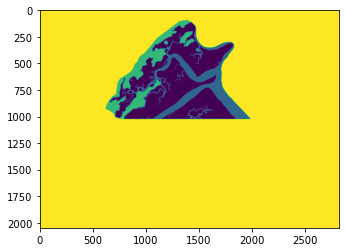

In [197]:
#see if it works
plt.imshow(te_masks[0,0])

# Converting to dataset

In [12]:
images.shape, masks.shape

((3, 11, 2048, 2816), (3, 1, 2048, 2816))

In [198]:
def get_tensor(images):
    images_tensor = tf.convert_to_tensor(images,dtype =tf.float32)
    
    SAMPLES,BANDS,HEIGHT,WIDTH = images_tensor.shape
    #print(list(a))
    #b = [1]
    #b.extend(list(a))
    #image_tensor = tf.reshape(images_tensor,[SAMPLES,HEIGHT,WIDTH,BANDS])
    image_tensor = tf.transpose(images_tensor,[0,2,3,1])
    return image_tensor

In [199]:
#get the data 

train_images = get_tensor(images)
train_masks = get_tensor(tr_masks)

test_images = get_tensor(images)

test_masks = get_tensor(te_masks)



train_dataset = tf.data.Dataset.from_tensor_slices((train_images,train_masks))

test_dataset = tf.data.Dataset.from_tensor_slices((test_images,test_masks))


#augmentations 

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])
#apply the augmentations; no idea why this num_parallel_calls is there
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)



train_batches = (
    train_dataset
    .cache()
    .shuffle(3)
    .batch(3)
    #.repeat()
    #.map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_dataset.batch(3)

# New shallower model
I'm going to try a much shallower model. I predict that it won't be able to differentiate ponds from ocean, but otherwise that it will outperform the deep model.

In [14]:
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output

## Results from previous models
1. depth 1 encoders: ?
2. depth 2 fully conv encoder/decoder; 5000 epochs .857 val accuracy
3. depth 2 enc/dec concat with a dilated conv. 3000 epochs .856 val accuracy. 
    * the "same" padding for the dilated convolution creates massive artifacts at the beginning. I fear the minimization just downweights the dilated conv layer to avoid this. Because I actually have much more image to work with, there should be a way to avoid this. Make my input and output sizes different, THEN use "same" padding.
4. kernel size from 2 to 4: 3000 epochs .79 val accuracy (more overfit).
5. using more of the image to avoid edge effects: still around .85 val accuracy, but faster training - got there after only 2000 epochs.
6. More channels? Wider - go up to 10. Not much benefit, slightly more overfitting - going back down to 5. Ummm, this did terribly - accuracy went down to 65 on val, and pretty bad on train too. Fluke? 
7. Remove dilated channel concat. Slower train, slightly worse fit.
8. Put back dilated channel all filters 5, dilated channel filter size only 2. Pretty ok - 83 val accuracy. Very few parameters, best in terms of simplicity. Welll... actually wihtout the dilated conv does just fine. Also - only train 2k epochs. 3k doesn't seem to help.
10. Increase depth? Made val accuracy worse (75 percent). Looks very "pixelated." Definitely need the skips.
11. Deeper and without the dilation - got a bit better, amusingly. like 82.
12. Add skips. Got worse - like 72. What the heck? Even training didn't crack 50. Somehow qualitatively not that bad, though.
13. Augmentations - not yet; haven't even fit the actual data yet.
14. Decrease stride to 1: Real bad, basically reversed marsh and water and all kinds of bad stuff. Honestly it's unclear why it even happened.
15. Add a stride 1 deconv at the end to avoid checkerboards - best so far .85. Still some checkerboarding in the ponds.
16. Added a skip for the input - improvement at  .86.
17. Increase first filter size: minor improvement, still at .86
18. Replaced stride 2 by max-pool - bloody awful. undid.
19. Replaced second filter by 4x4 filter - also terrible. undid, went back up.
20. Replaced the first conv2dTranspose by a 4x4; try to integrate more information. Terrible. 
21. Replace conv2dTranspose by dilated.




## More ideas to try 

1. Augmentation 
2. Rebalance classes; ponds underrepresented. Perhaps what's happening is that it's a local min to "not care about ponds"
3. Pre-train by filling in missing spots in other satellite imagery. 
4. Regularize - it does seem like i've successfully overfit at this point? Wait - I should be showing the training loss/accuracy tending to zero.

In [215]:
"""
#previous models 

#attempt no 1: just a single convolutional layer with filter 2x2 

#attempt no 2: encoder/decoder convolutional of depth 2, filters 2x2
#training for about 5000 epochs yielded val accuracy of .857

def shallow_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[None, None, 11])
    
    #down
    x = tf.keras.layers.Conv2D(filters=5,kernel_size=2,strides=2,activation="relu")(inputs)
    
    x = tf.keras.layers.Conv2D(10,2,2,activation="relu")(x)
    
    
    #up
    x = tf.keras.layers.Conv2DTranspose(5,2,2,activation="relu")(x)
    
    last = tf.keras.layers.Conv2DTranspose(
    filters=output_channels, kernel_size=2, strides=2,
    padding='same')
    
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)
    
#attempt no 3: depth 2 enc/dec concat with a dilated conv.

def shallow_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[None, None, 11])
    
    #down
    
    #convolutional
    x = tf.keras.layers.Conv2D(filters=5,kernel_size=2,strides=2,activation="relu")(inputs)
    
    
    #dilated convolution
    
    
    #usual convolution
    x = tf.keras.layers.Conv2D(filters=10,kernel_size=2,strides=2,activation="relu")(x)
    y = tf.keras.layers.Conv2D(filters=5,kernel_size=2,dilation_rate=10, padding="same",activation="relu")(x)
    
    #concat 
    concat = tf.keras.layers.Concatenate()
    x = concat([x,y])
    
    
    
    #up
    x = tf.keras.layers.Conv2DTranspose(5,2,2,activation="relu")(x)
    
    last = tf.keras.layers.Conv2DTranspose(
    filters=output_channels, kernel_size=2, strides=2,
    padding='same')
    
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)
    
#attempt no 4: increase filter sizes

def shallow_model(output_channels:int):
    #inputs = tf.keras.layers.Input(shape=[None, None, 11])
    
    #for debugging, fix input size
    inputs = tf.keras.layers.Input(shape=[256, 512, 11])
    
    #down
    
    #convolutional
    x = tf.keras.layers.Conv2D(filters=5,kernel_size=3,strides=2,activation="relu")(inputs)
    
    
    #dilated convolution
    
    
    #usual convolution
    x = tf.keras.layers.Conv2D(filters=10,kernel_size=3,strides=2,activation="relu")(x)
    y = tf.keras.layers.Conv2D(filters=5,kernel_size=3,dilation_rate=10, padding="same",activation="relu")(x)
    
    concat = tf.keras.layers.Concatenate()
    x = concat([x,y])
    
    
    
    #up
    x = tf.keras.layers.Conv2DTranspose(5,3,2,activation="relu")(x)
    
    last = tf.keras.layers.Conv2DTranspose(
    filters=output_channels, kernel_size=4, strides=2,activation="relu")
    
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)


"""

'\n#previous models \n\n#attempt no 1: just a single convolutional layer with filter 2x2 \n\n#attempt no 2: encoder/decoder convolutional of depth 2, filters 2x2\n#training for about 5000 epochs yielded val accuracy of .857\n\ndef shallow_model(output_channels:int):\n    inputs = tf.keras.layers.Input(shape=[None, None, 11])\n    \n    #down\n    x = tf.keras.layers.Conv2D(filters=5,kernel_size=2,strides=2,activation="relu")(inputs)\n    \n    x = tf.keras.layers.Conv2D(10,2,2,activation="relu")(x)\n    \n    \n    #up\n    x = tf.keras.layers.Conv2DTranspose(5,2,2,activation="relu")(x)\n    \n    last = tf.keras.layers.Conv2DTranspose(\n    filters=output_channels, kernel_size=2, strides=2,\n    padding=\'same\')\n    \n    x = last(x)\n    \n    return tf.keras.Model(inputs=inputs, outputs=x)\n    \n#attempt no 3: depth 2 enc/dec concat with a dilated conv.\n\ndef shallow_model(output_channels:int):\n    inputs = tf.keras.layers.Input(shape=[None, None, 11])\n    \n    #down\n    \n 

In [16]:
#depth 4 model with lots of concats

def shallow_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[XDIM, YDIM,11])
    
    #for debugging, fix input size
    #inputs = tf.keras.layers.Input(shape=[256, 512, 11])
    
    #down
    
    #first layer
    
    #convolutional
    x1 = tf.keras.layers.Conv2D(filters=5,kernel_size=4,strides=2,activation="relu",padding="same")(inputs)
    
    #second layer
    
    #usual convolution
    x2 = tf.keras.layers.Conv2D(filters=10,kernel_size=2,strides=2,activation="relu",padding="same")(x1)
    
    #maxpool
    #x2 = tf.keras.layers.MaxPooling2D(
    #pool_size=(2, 2), strides=None, padding="valid")(x2)
    
    
    """
    #dilated convolution
    y = tf.keras.layers.Conv2D(filters=5,kernel_size=2,dilation_rate=8, padding="valid",activation="relu")(x)
    
    #crop x to be same size as y so concat makes sense 
    #if x has shape x1,x2 and y has shape y1,y2 we want 
    #the part of x that starts at ((x1-y1)/2, (x2-y2)/2) and ends at ((x_1 + y_1)/2, (x_2 + y_2)/2)
    #i.e. the "middle y" of x.
    xdim1,xdim2 = x.shape[1],x.shape[2]
    ydim1,ydim2 = y.shape[1],y.shape[2]
    crop1 = (xdim1-ydim1)//2
    crop2 = (xdim2-ydim2)//2
    x = tf.keras.layers.Cropping2D(cropping=((crop1, crop2), (crop1, crop2)))(x)
    #need to make x,y same size before concatenating - simply cut off some of x?
    x = concat([x,y])
    """
    
    #third layer 
    
    x = tf.keras.layers.Conv2D(filters=10,kernel_size=2,strides=2,activation="relu",padding="same")(x2)
    #x = concat([x,x2])
    
    #up fourth layer
    
    x = tf.keras.layers.Conv2DTranspose(10,2,2,activation="relu",padding="same")(x)
    
    concat = tf.keras.layers.Concatenate()

    x = concat([x,x2])
    #fifth layer
    
    #dilation
    #x = tf.keras.layers.Conv2DTranspose(5,2,dilation_rate=2,activation="relu",padding="same")(x)
    #then upsample
    x = tf.keras.layers.Conv2DTranspose(5,2,2,activation="relu",padding="same")(x)
    
    last = tf.keras.layers.Conv2DTranspose(
    filters=5, kernel_size=2, strides=2,activation="relu")
    concat = tf.keras.layers.Concatenate()
    x = concat([x,x1])
    
    x=last(x)
    
    last = tf.keras.layers.Conv2DTranspose(
    filters=output_channels, kernel_size=2, strides=1, padding="same",activation="relu")
    
    concat = tf.keras.layers.Concatenate()
    x = concat([x,inputs])   
    x = last(x)
    
    #crop to correct output shape 
    
    #xdim1,xdim2 = x.shape[1],x.shape[2]
    #ydim1,ydim2 = y.shape[1],y.shape[2]
    #crop1 = (xdim1-ydim1)//2
    #crop2 = (xdim2-ydim2)//2
    #x = tf.keras.layers.Cropping2D(cropping=((PAD, PAD), (PAD, PAD)))(x)
    #need to make x,y same size before concatenating - simply cut off some of x?
    #x = concat([x,y])
    
    return tf.keras.Model(inputs=inputs, outputs=x)
    


In [186]:
#depth 2 model, no concats. Blocky output but best accuracy so far.

def shallow_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[None, None, 11])
    
    #down
    x = tf.keras.layers.Conv2D(filters=5,kernel_size=2,strides=2,activation="relu")(inputs)
    
    x = tf.keras.layers.Conv2D(10,2,2,activation="relu")(x)
    
    
    #up
    x = tf.keras.layers.Conv2DTranspose(5,2,2,activation="relu")(x)
    
    last = tf.keras.layers.Conv2DTranspose(
    filters=output_channels, kernel_size=2, strides=2,
    padding='same')
    
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

In [41]:
#straight up pixel-wise linear regression 

def shallow_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[None, None, 11])
    
    #down
    x = tf.keras.layers.Conv2D(filters=5,kernel_size=1,strides=1)(inputs)
    
    #x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

In [102]:
#dilated convolution 

def shallow_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[XDIM, YDIM, 11])
    
    #down
    
    #x = tf.keras.layers.Conv2D(filters=5,kernel_size=1,strides=1)(inputs)
    x = tf.keras.layers.Conv2D(filters=5,kernel_size=3,dilation_rate=8, padding="same",activation="relu")(inputs)
    #x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

In [141]:
#depth 2 model, try some strides and something to help with blocks

def shallow_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[None, None, 11])
    
    #concat with dilated conv
    x = tf.keras.layers.Conv2D(filters=5,kernel_size=3,dilation_rate=8, padding="same",activation="relu")(inputs)
    x = tf.keras.layers.Concatenate()([x,inputs])

    #down
    x = tf.keras.layers.Conv2D(filters=5,kernel_size=2,strides=2,activation="relu")(x)
    #concat with dilated conv 
    
    z = x
    
    
    
    
    x = tf.keras.layers.Conv2D(10,2,2,activation="relu")(x)
    
    
    #up
    x = tf.keras.layers.Conv2DTranspose(5,2,2,activation="relu")(x)
    
    #concat with dilated conv again
    y = tf.keras.layers.Conv2DTranspose(filters=5,kernel_size=3,dilation_rate=3,activation="relu",padding="same")(x)
    x = tf.keras.layers.Concatenate()([x,y,z])
    
    #concat with another dilated conv
    
    
    
    last = tf.keras.layers.Conv2DTranspose(
    filters=output_channels, kernel_size=2, strides=2,
    padding='same')
    
    
    #could make fewer channels 
    
    
    
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

In [156]:
#depth 2 model with one concat in the middle - falls into one class

def shallow_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[None, None, 11])
    

    #down
    x = tf.keras.layers.Conv2D(filters=5,kernel_size=2,strides=2,activation="relu")(inputs)
    #concat with dilated conv 
    
    z = x
    
    
    
    
    x = tf.keras.layers.Conv2D(10,2,2,activation="relu")(x)
    
    
    #up
    x = tf.keras.layers.Conv2DTranspose(5,2,2,activation="relu")(x)
    
    #concat with dilated conv again
    x = tf.keras.layers.Concatenate()([x,z])
    
    #concat with another dilated conv
    
    
    
    last = tf.keras.layers.Conv2DTranspose(
    filters=output_channels, kernel_size=2, strides=2,
    padding='same')
    
    
    #could make fewer channels 
    
    
    
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

In [187]:
#4 when tidal flats are merged 


OUTPUT_CLASSES = 4
#OUTPUT_CLASSES=5


model = shallow_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'],
              weighted_metrics=['accuracy']
             )

#The from_logits=True attribute inform the loss function that the output values generated 
#by the model are not normalized, a.k.a. logits. 
#In other words, the softmax function has not been applied on them to produce a probability distribution. 

#when does the thing re-randomize? Never?


In [188]:
model.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, None, None, 11)]  0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, None, None, 5)     225       
_________________________________________________________________
conv2d_35 (Conv2D)           (None, None, None, 10)    210       
_________________________________________________________________
conv2d_transpose_20 (Conv2DT (None, None, None, 5)     205       
_________________________________________________________________
conv2d_transpose_21 (Conv2DT (None, None, None, 4)     84        
Total params: 724
Trainable params: 724
Non-trainable params: 0
_________________________________________________________________


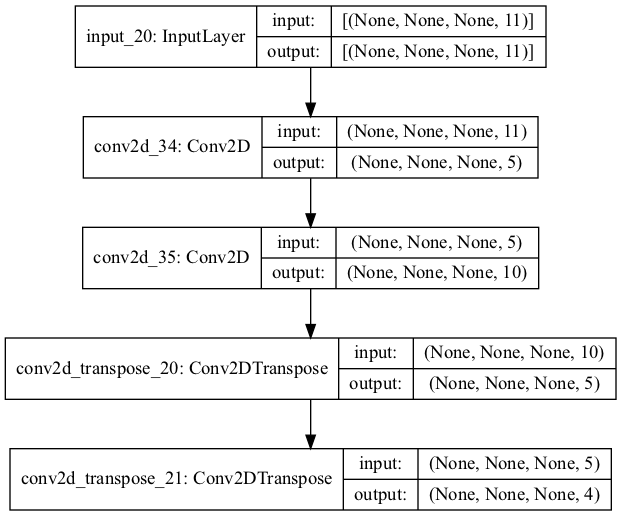

In [189]:
#256-208 = 48. try pad=24?
tf.keras.utils.plot_model(model, show_shapes=True)

In [84]:
#careful - could be long.
#for layer in model.layers: print(layer.get_config(), layer.get_weights())
[conv,bias] = model.layers[1].get_weights()  

In [85]:
conv = conv[0,0,:,:].T
conv

array([[ 0.23151231, -0.32393366,  0.1071313 , -0.59621775,  0.27501106,
        -0.04537362, -0.05937886,  0.5414762 ,  0.01349193,  0.47376555,
         0.21873266],
       [ 0.5313203 , -0.46281856, -0.5591662 , -0.53874403,  0.42970484,
         0.30587453,  0.37975115,  0.2771274 ,  0.00209659, -0.5985551 ,
         0.42729837],
       [ 0.03475261,  0.31894934,  0.06315362,  0.07468241, -0.00543135,
        -0.5907827 , -0.3744738 ,  0.42470533,  0.2858318 ,  0.30508977,
         0.05761212],
       [ 0.54664594,  0.18617535,  0.5664906 ,  0.0028708 ,  0.25008786,
        -0.18673041, -0.03792477, -0.12918633,  0.47573203,  0.03971857,
        -0.12623039],
       [-0.39614677, -0.405492  ,  0.02801162,  0.13050908, -0.1534333 ,
         0.30211073,  0.1368559 , -0.2299403 ,  0.18668151,  0.2639258 ,
         0.3723514 ]], dtype=float32)

In [69]:
conv.shape

(5, 11)

# Testing the model

Try out the model to check what it predicts before training.

In [201]:
for image,mask in test_dataset.take(1):
    sample_image,sample_mask = image, mask
for image,mask in train_dataset.take(1):
    sample_train_image,sample_train_mask = image, mask
sample_image.shape,sample_mask.shape

(TensorShape([2048, 2816, 11]), TensorShape([2048, 2816, 1]))

In [202]:
#to show the 
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image, mask[0,0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

def show_train_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0,0], create_mask(pred_mask)])
  else:
    display([sample_train_image, sample_train_mask,
             create_mask(model.predict(sample_train_image[tf.newaxis, ...]))])
    
def show_predictions_loaded(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = loaded_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(loaded_model.predict(sample_image[tf.newaxis, ...]))])
    
def display(display_list):
  plt.figure(figsize=(20, 20))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1,len(display_list),i+1)
    plt.title(title[i])
    if display_list[i].shape[-1]==1:
        mi = 0
        ma = 3
    else:
        mi = 4
        ma = 7
    plt.imshow(tf.keras.utils.array_to_img(display_list[i][:,:,mi:ma]))
    plt.axis('off')
  plt.show()

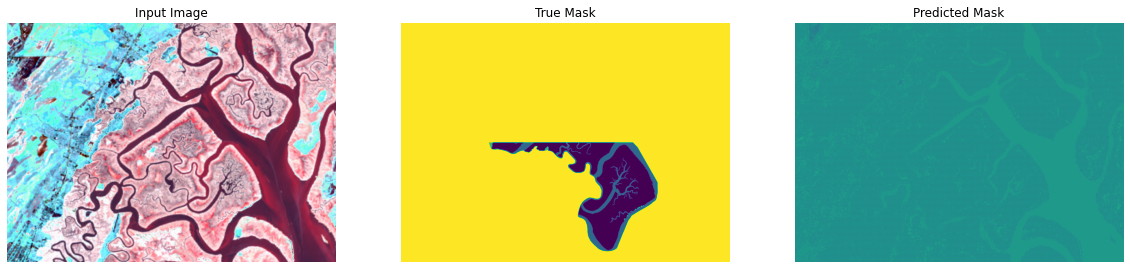

In [203]:
show_train_predictions()
#looks buggy for linear. Essentially should just be random - how can it be always choosing one value?

# Training the model

In [204]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    if epoch % 5==0:
        clear_output(wait=True)
        show_predictions()
    #show_train_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
tb_callback = tf.keras.callbacks.TensorBoard('./logs/MergeTidal', update_freq=5)

2022-06-10 11:17:40.170502: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2022-06-10 11:17:40.170542: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2022-06-10 11:17:40.171425: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.


In [192]:
## adding sample weights so that the final class is ignored 

def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([1/counts[0],1/counts[1],1/counts[2], 0.0])
  #class_weights = tf.constant(inv_freq)
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

In [185]:
train_batches.map(add_sample_weights).element_spec

(TensorSpec(shape=(None, 2048, 2816, 11), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 2048, 2816, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 2048, 2816, 1), dtype=tf.float32, name=None))

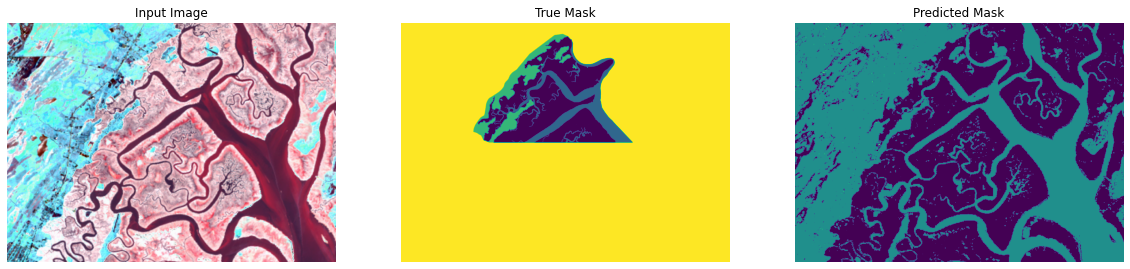


Sample Prediction after epoch 2996

Epoch 2997/3000
1/1 [==============================] - 3s 3s/step - loss: 0.0287 - accuracy: 0.1357 - weighted_accuracy: 0.7049 - val_loss: 0.0746 - val_accuracy: 0.1345 - val_weighted_accuracy: 0.5340

Sample Prediction after epoch 2997

Epoch 2998/3000
1/1 [==============================] - 3s 3s/step - loss: 0.0288 - accuracy: 0.1378 - weighted_accuracy: 0.7027 - val_loss: 0.0742 - val_accuracy: 0.1331 - val_weighted_accuracy: 0.5430

Sample Prediction after epoch 2998

Epoch 2999/3000
1/1 [==============================] - 3s 3s/step - loss: 0.0287 - accuracy: 0.1353 - weighted_accuracy: 0.7051 - val_loss: 0.0746 - val_accuracy: 0.1346 - val_weighted_accuracy: 0.5335

Sample Prediction after epoch 2999

Epoch 3000/3000
1/1 [==============================] - 3s 3s/step - loss: 0.0288 - accuracy: 0.1379 - weighted_accuracy: 0.7025 - val_loss: 0.0742 - val_accuracy: 0.1332 - val_weighted_accuracy: 0.5424

Sample Prediction after epoch 3000



In [205]:
#actually training 

EPOCHS = 3000
#VAL_SUBSPLITS = 5
#VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS


model_history = model.fit(train_batches.map(add_sample_weights), 
                          #class_weight = {0:1,1:1,2:1,3:1,4:0},
                          epochs=EPOCHS,
                          #steps_per_epoch=STEPS_PER_EPOCH,
                          #validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches.map(add_sample_weights),
                          callbacks=[DisplayCallback(),tb_callback]
                         )

In [94]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [206]:
%tensorboard --logdir logs/

Reusing TensorBoard on port 6006 (pid 88836), started 3:32:33 ago. (Use '!kill 88836' to kill it.)

## What is going wrong?

In [122]:
pred_mask = model.predict(sample_train_image[tf.newaxis, ...])

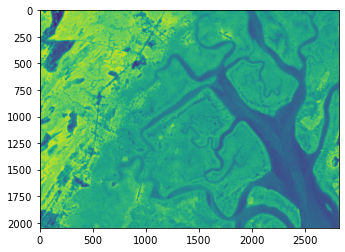

In [34]:
plt.imshow(pred_mask[0,:,:,4])

In [124]:
mask_max = create_mask(pred_mask)

In [178]:
# hmmm, strange mixture of classes.
mask_max[250:255,500:505,0]
#maybe I need some max-pooling!

<tf.Tensor: shape=(5, 5), dtype=int64, numpy=
array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 1, 1, 1, 2],
       [1, 1, 1, 1, 2],
       [1, 1, 1, 0, 2]])>

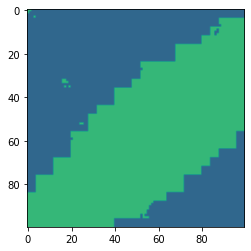

In [125]:
plt.imshow(mask_max[1000:1100,1000:1100,0],vmin=0,vmax=3)

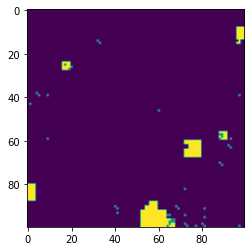

In [177]:
plt.imshow(mask_max[1300:1400,1900:2000,0])

In [185]:
mask_max[1020:1030,1020:1030,0], masks[0,0,1020:1030,1020:1030]

(<tf.Tensor: shape=(10, 10), dtype=int64, numpy=
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])>,
 array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]))

In [38]:
pred_mask[0,1020:1025,1020:1025,:]

array([[[205.87259  ,  23.97259  , 164.44249  , 377.91324  ,
          66.81957  ],
        [205.87236  ,  25.785074 , 163.58437  , 379.46356  ,
          66.61588  ],
        [208.03827  ,  26.89358  , 165.28319  , 378.9468   ,
          65.69613  ],
        [208.03827  ,  26.89358  , 165.28319  , 378.9468   ,
          65.69613  ],
        [208.03827  ,  26.89358  , 165.28319  , 378.9468   ,
          65.69613  ]],

       [[206.26157  ,  25.114756 , 164.21327  , 377.03085  ,
          66.86375  ],
        [206.95532  ,  26.33932  , 164.43378  , 379.20517  ,
          66.156    ],
        [208.57974  ,  27.17071  , 165.7079   , 378.81763  ,
          65.46618  ],
        [208.57974  ,  27.17071  , 165.7079   , 378.81763  ,
          65.46618  ],
        [208.56625  ,  27.168604 , 165.42207  , 378.3419   ,
          65.2795   ]],

       [[209.5558   ,  26.471643 , 167.35228  , 376.44244  ,
          65.182    ],
        [209.64922  ,  27.722864 , 166.27148  , 378.0835   ,
          6

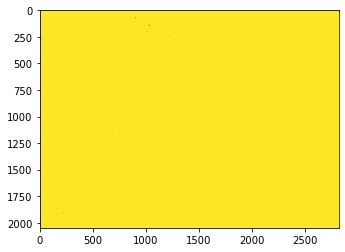

In [36]:
plt.imshow(mask_max)

In [92]:
np.histogram(mask_max)

(array([3199734,       0,       0, 1088898,       0,       0, 1478162,
              0,       0,     374]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]))

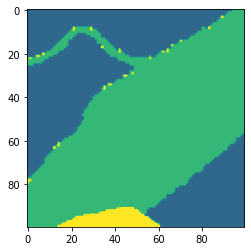

In [208]:
plt.imshow(masks[0,0,1000:1100,1000:1100],vmin=0,vmax=3)

In [107]:
masks[0,0,1020:1030,1020:1030]

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

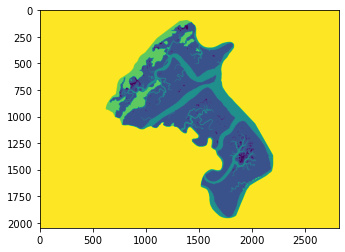

In [102]:
plt.imshow(masks[0,0,:,:])

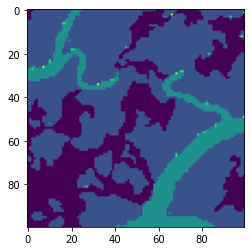

In [209]:
plt.imshow(masks[0,0,1300:1400,1900:2000])

In [131]:
lil_pred = create_mask(model.predict(lil_image))

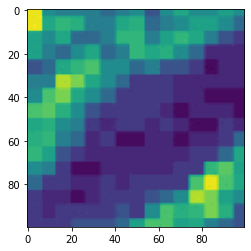

In [114]:
plt.imshow(images[0,0,1000:1100,1000:1100])

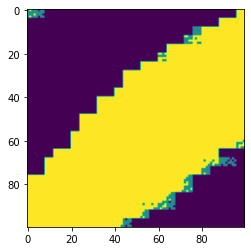

In [132]:
plt.imshow(lil_pred)

In [122]:
sample_train_image[tf.newaxis, ...].shape, get_tensor(images[:,:,1000:1100,1000:1100]).shape, lil_pred.shape

(TensorShape([1, 2048, 2816, 11]),
 TensorShape([3, 100, 100, 11]),
 (3, 100, 100, 5))

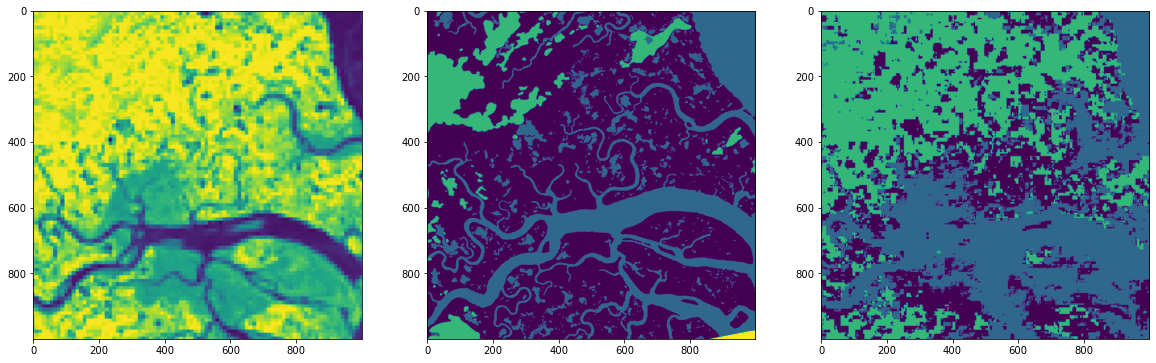

In [237]:
#zooming 

zoomx = 1000
zoomy = 1000
startx = 750
starty = 1000
which_img = 1
which_band = 4


lil_image = get_tensor(images[which_img,:,startx:(startx + zoomx) ,starty:(starty + zoomy)].reshape([1,11,zoomx,zoomy]))

lil_logits = model.predict(lil_image)

lil_pred = create_mask(lil_logits)

lil_mask = masks[which_img,0,startx:(startx + zoomx) ,starty:(starty + zoomy)]

#plt.imshow(lil_pred)
#display([[lil_image[:,:,which_band], lil_mask, lil_pred]])

#display([lil_image[0,:,:,:], lil_mask,lil_pred])
plt.figure(figsize=(20, 20))
plt.subplot(131)
plt.imshow(lil_image[0,:,:,which_band])
plt.subplot(132)
plt.imshow(lil_mask,vmin=0, vmax=3)
plt.subplot(133)
plt.imshow(lil_pred,vmin=0, vmax=3)

#some bugs for sure. Something with the low resolution of the image? 
#I think we're going to have to use a more dilated convolution.


In [82]:
#why would this be happening!!? Ok so basically the image entries are large and positive, but the weights look uniform. 

lil_image,lil_logits

(<tf.Tensor: shape=(1, 5, 5, 11), dtype=float32, numpy=
 array([[[[186., 184., 202., 199., 202., 184., 191., 207., 220., 184.,
           186.],
          [186., 184., 202., 199., 202., 184., 191., 204., 220., 184.,
           186.],
          [186., 184., 202., 199., 202., 184., 191., 196., 219., 184.,
           186.],
          [186., 184., 202., 199., 202., 184., 191., 196., 220., 184.,
           186.],
          [186., 184., 202., 199., 202., 184., 191., 195., 220., 184.,
           186.]],
 
         [[186., 184., 202., 199., 202., 184., 191., 212., 220., 184.,
           186.],
          [186., 184., 202., 199., 202., 184., 191., 207., 220., 184.,
           186.],
          [186., 184., 202., 199., 202., 184., 191., 196., 220., 184.,
           186.],
          [186., 184., 202., 199., 202., 184., 191., 195., 220., 184.,
           186.],
          [186., 184., 202., 199., 202., 184., 191., 196., 220., 184.,
           186.]],
 
         [[191., 190., 204., 204., 223., 191., 1

In [86]:
inp = np.array(lil_image[0,0,0,:])
print(conv,inp)
conv@inp
#conv @ inp
#I understand NOTHING - it does match, but why these crazy dimensions? Ah - they are all hovering around 200.
#probably if we do it again, we'd expect different values but still similar behavior for all.

[[ 0.23151231 -0.32393366  0.1071313  -0.59621775  0.27501106 -0.04537362
  -0.05937886  0.5414762   0.01349193  0.47376555  0.21873266]
 [ 0.5313203  -0.46281856 -0.5591662  -0.53874403  0.42970484  0.30587453
   0.37975115  0.2771274   0.00209659 -0.5985551   0.42729837]
 [ 0.03475261  0.31894934  0.06315362  0.07468241 -0.00543135 -0.5907827
  -0.3744738   0.42470533  0.2858318   0.30508977  0.05761212]
 [ 0.54664594  0.18617535  0.5664906   0.0028708   0.25008786 -0.18673041
  -0.03792477 -0.12918633  0.47573203  0.03971857 -0.12623039]
 [-0.39614677 -0.405492    0.02801162  0.13050908 -0.1534333   0.30211073
   0.1368559  -0.2299403   0.18668151  0.2639258   0.3723514 ]] [186. 184. 202. 199. 202. 184. 191. 207. 220. 184. 186.]


array([165.22374 ,  36.289062, 129.09323 , 321.59937 ,  45.362133],
      dtype=float32)

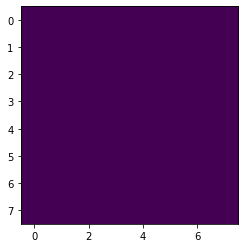

In [146]:
plt.imshow(lil_mask)

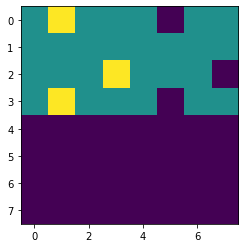

In [142]:
plt.imshow(lil_pred)

# saving/loading

In [207]:
model.save('2deep3000epochs54val')

INFO:tensorflow:Assets written to: 2deep3000epochs54val/assets


In [ ]:
loaded_model = tf.keras.models.load_model('saved-model-unpatched')

In [ ]:
show_predictions_loaded()

## More ideas

1. The pixelation in the image is really bad - looks to be around 7x7 in the mask resolution. Should probably include some kind of dilated conv so that nearby pixels can even see eachother. The pixelation 
2. Make sure there's no serious bug - at some point was getting a checkerboard pattern, but it disappeared after using the model to predict more stuff? Does this have to do with the None/None shape?
3. Keep messing with the class weights. Or just merge some things to get it predicting marsh and non-marsh.
    * Tried weights count^{-1/2}. Got accuracy around 54 for train, 46 for val. Still didn't pick up the zero stuff, but accuracy was climbing. Can return to this model for more iterations.
    * Merging tidal and Marsh seems to help quite a bit, but the model is still identifying it as water. 
    * It's not identifying upland at all. I think I should check out what it's doing on the other images.
4. Debug with linear model. This turned out to be very helpful - understood that there's perfect reproducibility as long as you don't change the model, also learned how initialization can be weird. Also, this task is very hard to learn perfectly as you can only get a percentage of each pixel correct. It will learn to predict the majority in the pixel, which will definitely not allow it to see small channels.
5. Can force it never to guess the dont_care class - this should mildly speed up training

## Interpretation

1. What bands are being used?
2. Can we interpret the intermediate channels as features indicating marsh?